In [1]:
import pynq
import numpy as np
import matplotlib.pyplot as plt
pynq.PL.reset()
ol = pynq.Overlay("DMA_transfer.bit")

In [2]:
#Parameters
samples = 10000
clk_freq = 125e6

#Time array
t = np.arange(samples) / clk_freq

#Gaussian
t_center = 0.5 * samples / clk_freq
t_width =  0.15 * samples / clk_freq
gaussian = np.exp(-(t - t_center)**2 / (2 * t_width**2))

#Sin/Cos
freq = 200e3
sin = np.sin(2 * np.pi * freq * t)
cos = np.cos(2 * np.pi * freq * t)

#Waveforms
waveform_out_1= np.array((2**15 - 1) * sin * gaussian, dtype=np.int16)
waveform_out_2= np.array((2**15 - 1) * cos * gaussian, dtype=np.int16)


In [3]:
input_buffer_1 = pynq.allocate(shape=(samples,), dtype=np.int16)
output_buffer_1 = pynq.allocate(shape=(samples,), dtype=np.int16)
input_buffer_2 = pynq.allocate(shape=(samples,), dtype=np.int16)
output_buffer_2 = pynq.allocate(shape=(samples,), dtype=np.int16)

np.copyto(output_buffer_1, waveform_out_1)
np.copyto(output_buffer_2, waveform_out_2)

In [4]:
ol.axi_gpio_0.channel1.write(val=0, mask=0x1) #Trig low
ol.axi_gpio_0.channel2.write(val=samples, mask=0xffffffff) #Set samples

ol.axi_dma_0.recvchannel.transfer(input_buffer_1)
ol.axi_dma_0.sendchannel.transfer(output_buffer_1)
ol.axi_dma_1.recvchannel.transfer(input_buffer_2)
ol.axi_dma_1.sendchannel.transfer(output_buffer_2)

ol.axi_gpio_0.channel1.write(val=1, mask=0x1) #Trig high

ol.axi_dma_0.recvchannel.wait()
ol.axi_dma_0.sendchannel.wait()
ol.axi_dma_1.recvchannel.wait()
ol.axi_dma_1.sendchannel.wait()

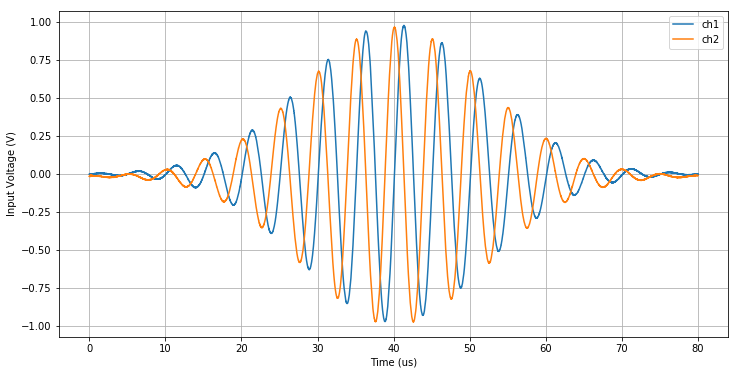

In [5]:
plt.figure(figsize=(12,6))
plt.plot(t * 10**6, input_buffer_1 / 2**15, label = "ch1")
plt.plot(t * 10**6, input_buffer_2 / 2**15, label = "ch2")
plt.xlabel("Time (us)")
plt.ylabel("Input Voltage (V)")
plt.grid()
plt.legend()
plt.show()